In [1]:
import os
data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
#Read the file
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
#Extract the first line
header = lines[0].split(',')
#Extract rest of the lines
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    #Split every line based on comma and save it into numpy array
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
print(float_data[0][10])

1307.75


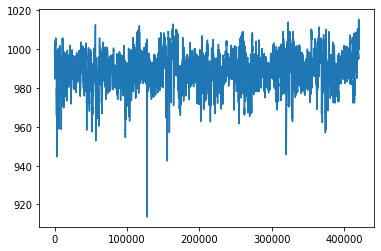

In [4]:
#Plot the data
%matplotlib inline
from matplotlib import pyplot as plt
temp = float_data[:, 0]
plt.plot(range(len(temp)), temp)

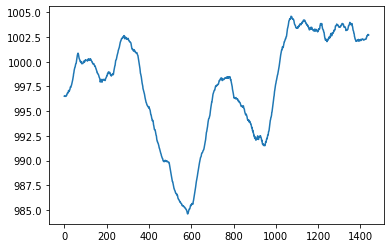

In [5]:
plt.plot(range(1440), temp[:1440])

In [6]:
# Normalize the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None: #If max index is not specified, we will set it to very end of the data
        max_index = len(data) - delay - 1
    i = min_index + lookback #Set i to the very start of the data
    while 1:
        if shuffle:
            #Generate random rows
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
step = 3
lookback = 720
delay = 144

In [9]:
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,
                      shuffle=True,step=step)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,
                    max_index=300000,step=step)
test_gen = generator(float_data,lookback=lookback,delay=delay,
                     min_index=300001,max_index=None,step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128


In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

Using TensorFlow backend.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 209s 419ms/step - loss: nan - val_loss: nan
Epoch 2/20
500/500 [==============================] - 215s 431ms/step - loss: nan - val_loss: nan
Epoch 3/20
336/500 [===================>..........] - ETA: 49s - loss: nan